In [1]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import learning_curve
from sklearn.neighbors import KernelDensity

In [2]:
import warnings
warnings.filterwarnings('ignore')

### <u>Load Data</u> 

In [3]:
# Load the data from an Excel file
df = pd.read_excel("Grade_CS_Students.xlsx", na_values=['NA'])

# Display the first few rows of the dataframe
df.head()

,Year of enrolment,ID,CS101,CS102,MA101,MA112,MA121,GS101,GS102,PH101,...,CS507,CS508,CS509,CS510,CS512,CS597,CS598,MA419,SW499,MM507
0,2005-2008,ST1,40,51,40,NaN,40,44,57,40,...,50,42.0,67.0,46.0,43.0,63.0,70.0,58.0,63.0,NaN
1,NaN,ST2,40,40,46,NaN,40,48,45,40,...,41,40.0,49.0,40.0,40.0,60.0,70.0,69.0,70.0,NaN
2,NaN,ST3,53,77,45,NaN,40,48,50,40,...,54,41.0,67.0,41.0,40.0,62.0,76.0,63.0,66.0,NaN
3,NaN,ST4,40,41,40,NaN,40,40,44,40,...,44,56.0,55.0,40.0,40.0,66.0,64.0,46.0,66.0,NaN
4,NaN,ST5,51,52,50,NaN,40,67,54,40,...,52,40.0,40.0,64.0,43.0,60.0,71.0,51.0,66.0,NaN


#### stats

In [4]:
# display descriptive statistics for the DataFrame
print("Descriptive statistics:")
print(df.describe())

Descriptive statistics:
            CS101       CS102       MA101       MA112       MA121       GS101  \
count  335.000000  335.000000  335.000000  298.000000  335.000000  335.000000   
mean    57.543284   59.749254   54.576119   47.583893   50.098507   59.856716   
std     10.406286   10.410574   12.132972    8.900195   11.160204   12.769387   
min     40.000000   40.000000   40.000000   40.000000   40.000000   40.000000   
25%     50.000000   51.000000   44.500000   40.000000   40.000000   48.500000   
50%     57.000000   60.000000   52.000000   45.000000   48.000000   61.000000   
75%     65.000000   67.000000   63.000000   52.000000   55.500000   70.000000   
max     83.000000   85.000000   89.000000   89.000000   91.000000   91.000000   

            GS102       PH101       PH102       PH103  ...       CS507  \
count  335.000000  335.000000  335.000000  316.000000  ...  335.000000   
mean    52.426866   47.462687   50.164179   47.363924  ...   54.695522   
std      8.615534    8.0

In [5]:
# Display the number of null values in each column
print("Number of null values in each column:")
print(df.isnull().sum())

Number of null values in each column:
Year of enrolment    328
ID                     0
CS101                  0
CS102                  0
MA101                  0
                    ... 
CS597                  1
CS598                  1
MA419                  1
SW499                  1
MM507                 75
Length: 68, dtype: int64


#### #of Nulls

In [6]:
# Count Non-Numeric Values
# Create a dictionary to store the count of non-numeric values
non_numeric_counts = {}

# Loop through each column to count non-numeric values
for col in df.columns:
    # Convert to numeric, set non-numeric to NaN
    non_numeric_col = pd.to_numeric(df[col], errors='coerce')
    # Count NaN values (which represent non-numeric values)
    non_numeric_counts[col] = non_numeric_col.isna().sum()

# Convert the dictionary to a DataFrame for better readability
non_numeric_counts_df = pd.DataFrame(list(non_numeric_counts.items()), columns=['Column', 'Non-Numeric Count'])

# Display the counts
print(non_numeric_counts_df)

               Column  Non-Numeric Count
0   Year of enrolment                335
1                  ID                335
2               CS101                  0
3               CS102                  0
4               MA101                  0
..                ...                ...
63              CS597                  1
64              CS598                  1
65              MA419                  1
66              SW499                  1
67              MM507                 75

[68 rows x 2 columns]


#### drop un necessary colms

In [7]:
# drop unnecessary columns
df = df.drop(['Year of enrolment', 'ID'], axis=1)

df.head()

,CS101,CS102,MA101,MA112,MA121,GS101,GS102,PH101,PH102,PH103,...,CS507,CS508,CS509,CS510,CS512,CS597,CS598,MA419,SW499,MM507
0,40,51,40,NaN,40,44,57,40,40,NaN,...,50,42.0,67.0,46.0,43.0,63.0,70.0,58.0,63.0,NaN
1,40,40,46,NaN,40,48,45,40,52,40.0,...,41,40.0,49.0,40.0,40.0,60.0,70.0,69.0,70.0,NaN
2,53,77,45,NaN,40,48,50,40,45,40.0,...,54,41.0,67.0,41.0,40.0,62.0,76.0,63.0,66.0,NaN
3,40,41,40,NaN,40,40,44,40,40,46.0,...,44,56.0,55.0,40.0,40.0,66.0,64.0,46.0,66.0,NaN
4,51,52,50,NaN,40,67,54,40,42,40.0,...,52,40.0,40.0,64.0,43.0,60.0,71.0,51.0,66.0,NaN


#### divide dataset to features & targets

In [8]:
# divide features and targets
target_subjects = ['CS501','CS502','CS503','CS504','CS505','CS506','CS507','CS508','CS509','CS510','CS512','CS597','CS598','MM507'] 
features = df.drop(target_subjects, axis=1)
targets = df[target_subjects]

# temp
target = df['CS501']

print("features : ", features.shape, "\ntargets : ", target.shape)





features :  (335, 52) 
targets :  (335,)


#### distribution of each feature 

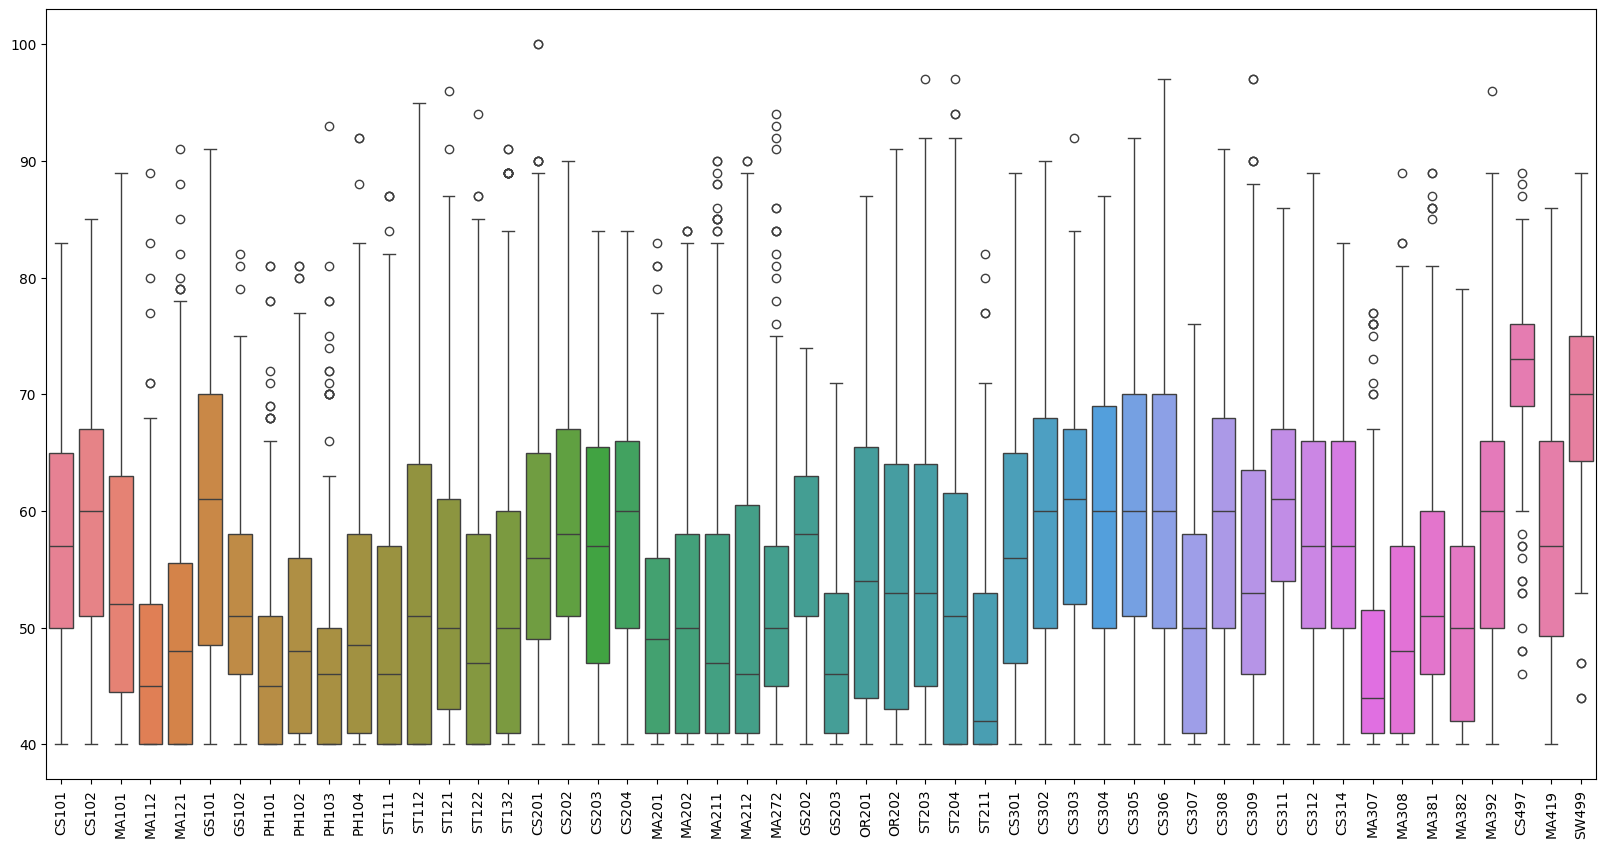

In [9]:
# plot the box plot for each column in features
plt.figure(figsize=(20, 10))
sns.boxplot(data=features)
plt.xticks(rotation=90)
plt.show()


### <u>Pre Processesing</u>

#### replace NULLs

In [10]:
# replace null values

for col in features.columns:
    features[col] = pd.to_numeric(features[col], errors='coerce')  # Convert to numeric, set non-numeric to NaN
    features.fillna({col: features[col].median()}, inplace=True)  # Fill NaN with median of the column

# Verify the changes
features.head()


,CS101,CS102,MA101,MA112,MA121,GS101,GS102,PH101,PH102,PH103,...,CS312,CS314,MA307,MA308,MA381,MA382,MA392,CS497,MA419,SW499
0,40,51,40,45.0,40,44,57,40,40,46.0,...,61,45,42,41,50,40,50,75,58.0,63.0
1,40,40,46,45.0,40,48,45,40,52,40.0,...,68,65,40,40,50,41,74,73,69.0,70.0
2,53,77,45,45.0,40,48,50,40,45,40.0,...,64,70,61,54,48,43,44,66,63.0,66.0
3,40,41,40,45.0,40,40,44,40,40,46.0,...,43,47,40,40,52,40,69,66,46.0,66.0
4,51,52,50,45.0,40,67,54,40,42,40.0,...,51,55,43,42,40,48,47,75,51.0,66.0


In [11]:
print(features.isnull().sum())

CS101    0
CS102    0
MA101    0
MA112    0
MA121    0
GS101    0
GS102    0
PH101    0
PH102    0
PH103    0
PH104    0
ST111    0
ST112    0
ST121    0
ST122    0
ST132    0
CS201    0
CS202    0
CS203    0
CS204    0
MA201    0
MA202    0
MA211    0
MA212    0
MA272    0
GS202    0
GS203    0
OR201    0
OR202    0
ST203    0
ST204    0
ST211    0
CS301    0
CS302    0
CS303    0
CS304    0
CS305    0
CS306    0
CS307    0
CS308    0
CS309    0
CS311    0
CS312    0
CS314    0
MA307    0
MA308    0
MA381    0
MA382    0
MA392    0
CS497    0
MA419    0
SW499    0
dtype: int64


#### encode values

In [12]:
def encode_grade(marks):

# Convert scores into grades

    if marks > 85:
        return 0  #'A+'
    elif 80 <= marks <= 85:
        return 1  #'A'
    elif 75 <= marks < 80:
        return 2  #'A-'
    elif 70 <= marks < 75:
        return 3  #'B+'
    elif 65 <= marks < 70:
        return 4  #'B'
    elif 60 <= marks < 65:
        return 5  #'B-'
    elif 55 <= marks < 60:
        return 6  #'C+'
    elif 50 <= marks < 55:
        return 7  #'C'
    elif 45 <= marks < 50:
        return 8  #'C-'
    elif 40 <= marks < 45:
        return 9 #'D+'
    elif 35 <= marks < 40:
        return 10 #'D'
    else:
        return 11 #'E'


# Apply the grade encoding function to each cell in the dataframe
features_encoded = features.map(encode_grade)


features_encoded.head()

,CS101,CS102,MA101,MA112,MA121,GS101,GS102,PH101,PH102,PH103,...,CS312,CS314,MA307,MA308,MA381,MA382,MA392,CS497,MA419,SW499
0,9,7,9,8,9,9,6,9,9,8,...,5,8,9,9,7,9,7,2,6,5
1,9,9,8,8,9,8,8,9,7,9,...,4,4,9,9,7,9,3,3,4,3
2,7,2,8,8,9,8,7,9,8,9,...,5,3,5,7,8,9,9,4,5,4
3,9,9,9,8,9,9,9,9,9,8,...,9,8,9,9,7,9,4,4,8,4
4,7,7,7,8,9,4,7,9,9,9,...,7,6,9,9,9,8,8,2,7,4


In [13]:
# Encode targets
targets_encoded = targets.map(encode_grade)

targets_encoded.head()

,CS501,CS502,CS503,CS504,CS505,CS506,CS507,CS508,CS509,CS510,CS512,CS597,CS598,MM507
0,9,4,9,6,5,8,7,9,4,8,9,5,3,11
1,7,7,9,8,8,9,9,9,8,9,9,5,3,11
2,6,0,9,7,7,5,7,9,4,9,9,5,2,11
3,7,6,8,7,8,6,9,6,6,9,9,4,5,11
4,7,8,9,4,9,8,7,9,9,5,9,5,3,11


#### Correlation between features

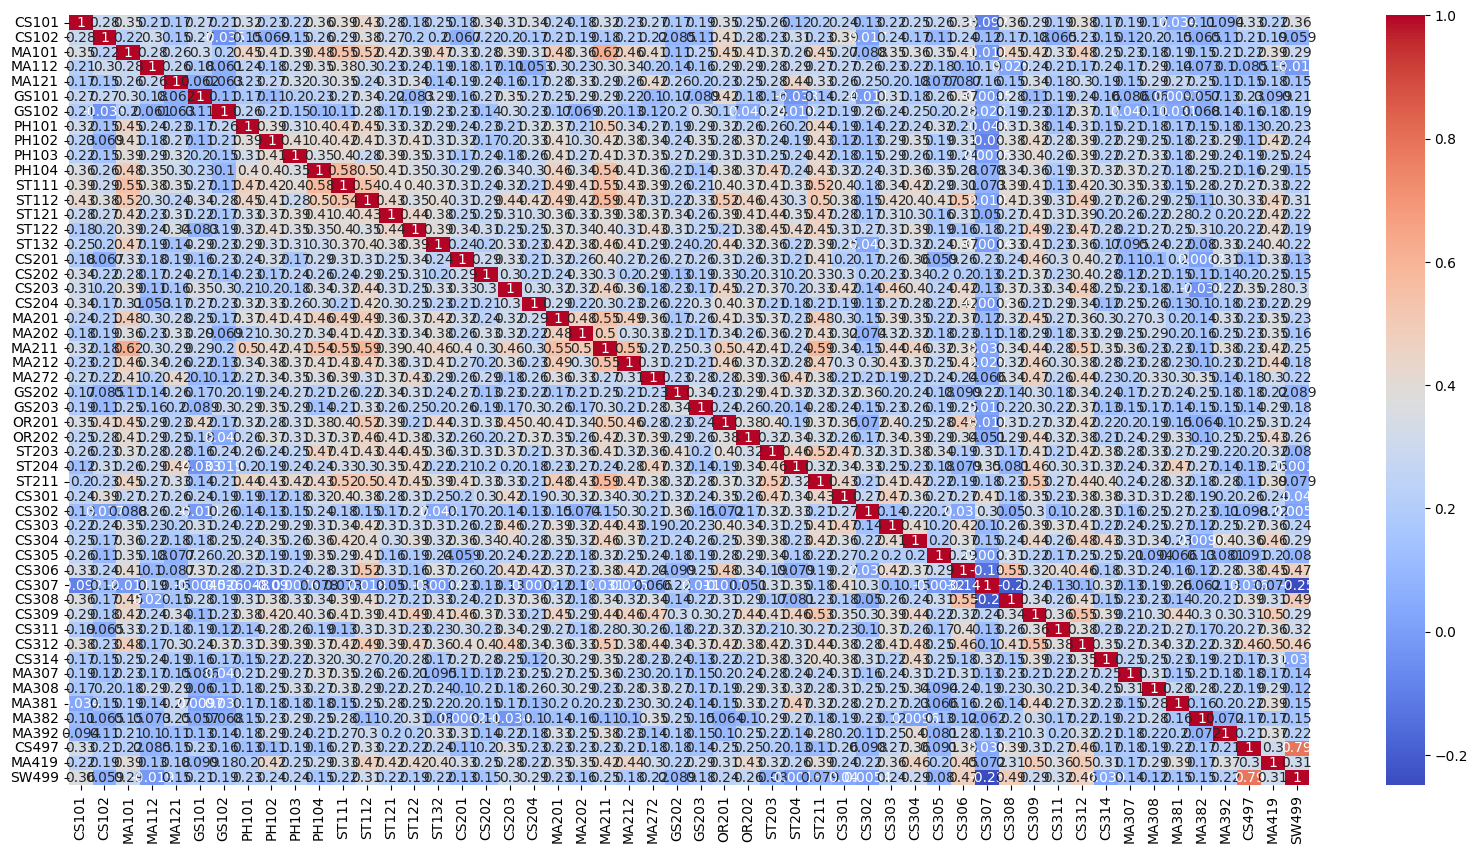

In [14]:
# plot correlation matrix for encoded features use blue for negative correlation and red for positive correlation
plt.figure(figsize=(20, 10))
sns.heatmap(features_encoded.corr(), annot=True, cmap='coolwarm')
plt.show()


#### correlation between features and targets

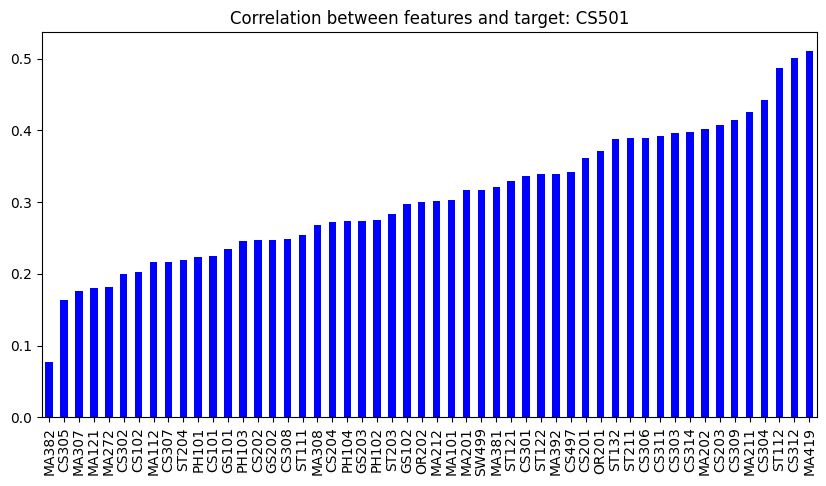

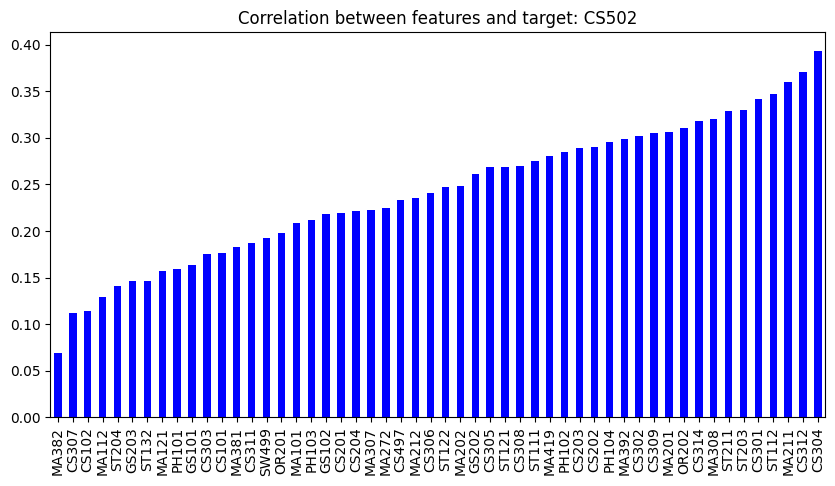

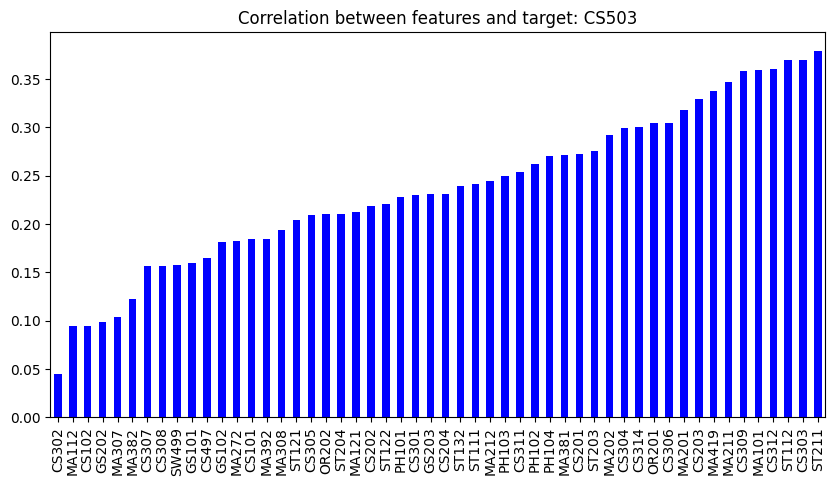

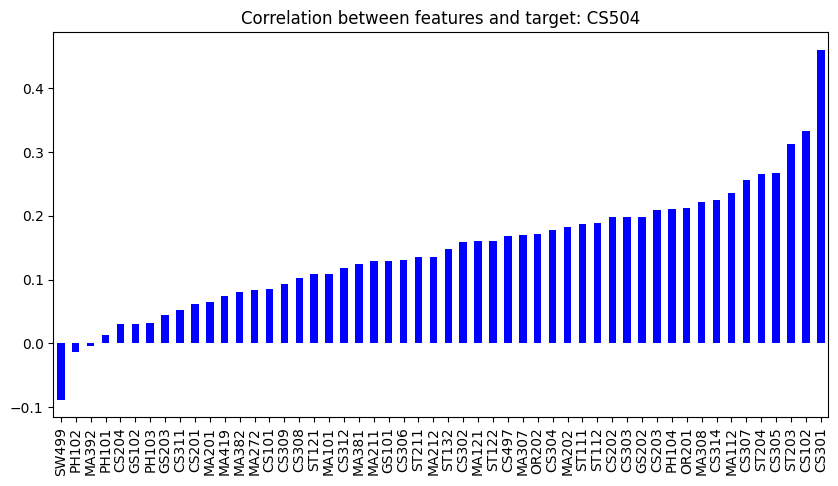

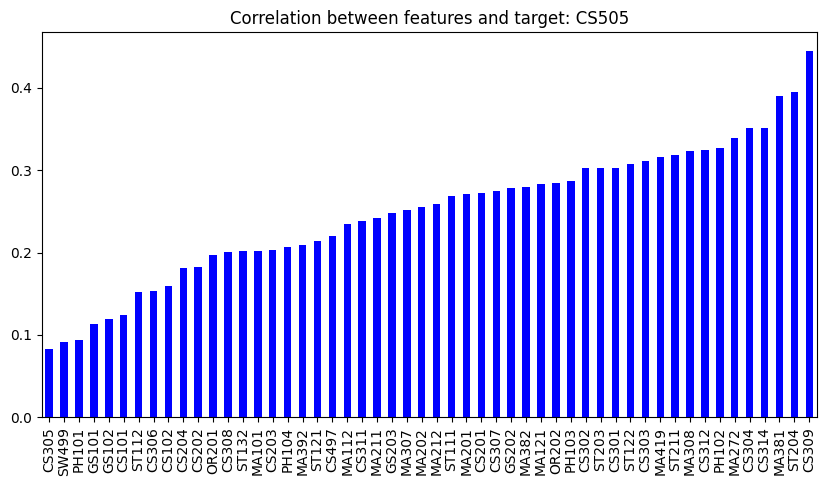

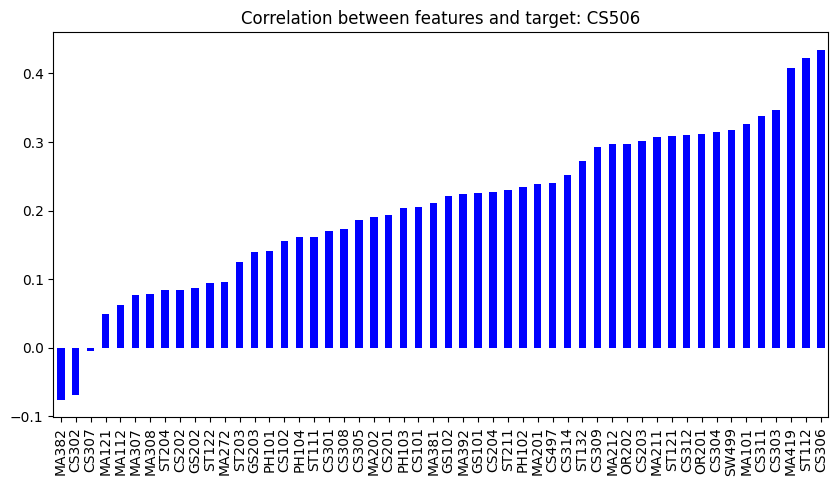

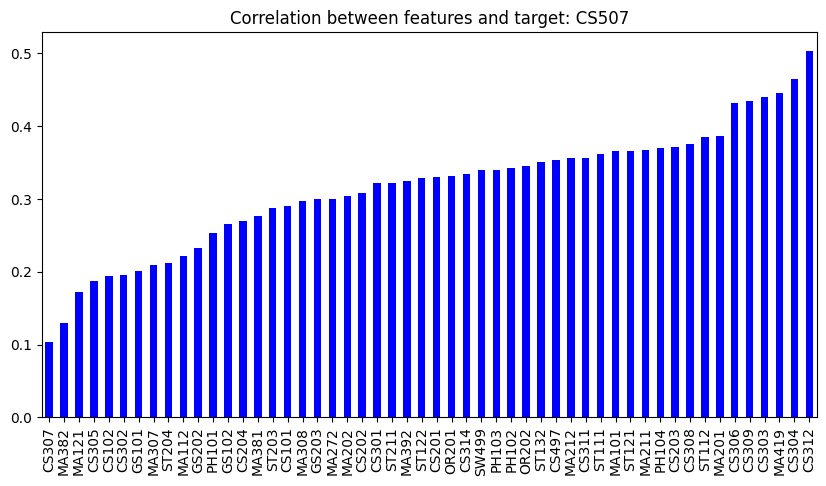

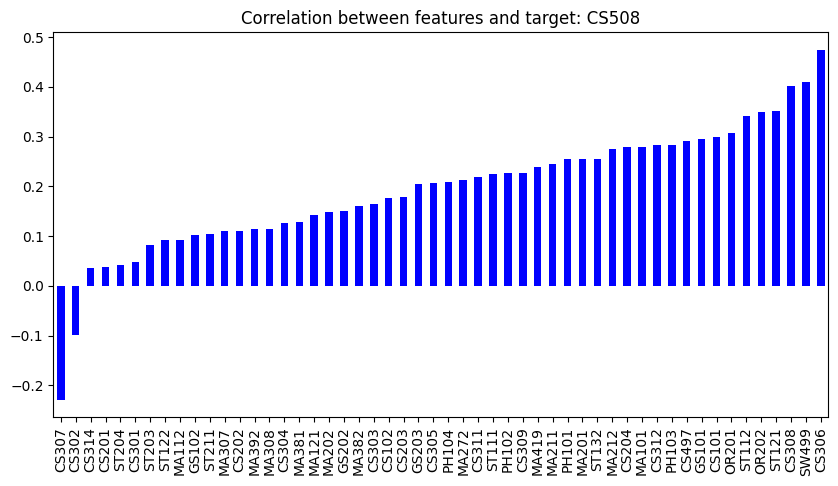

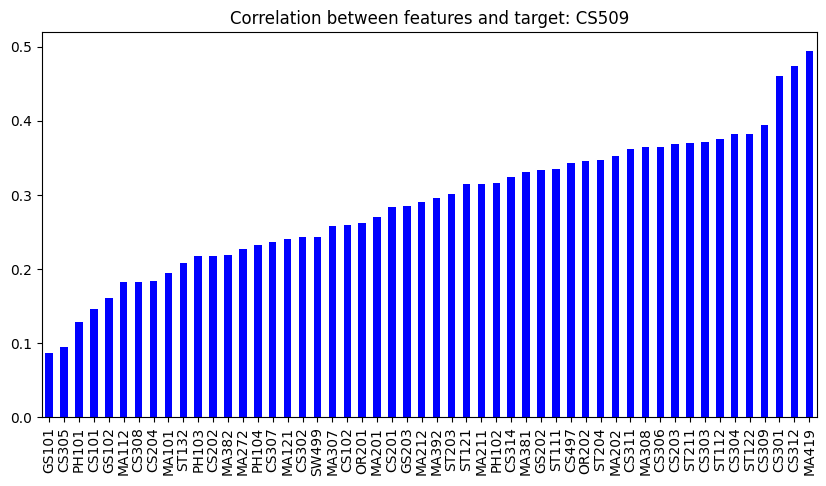

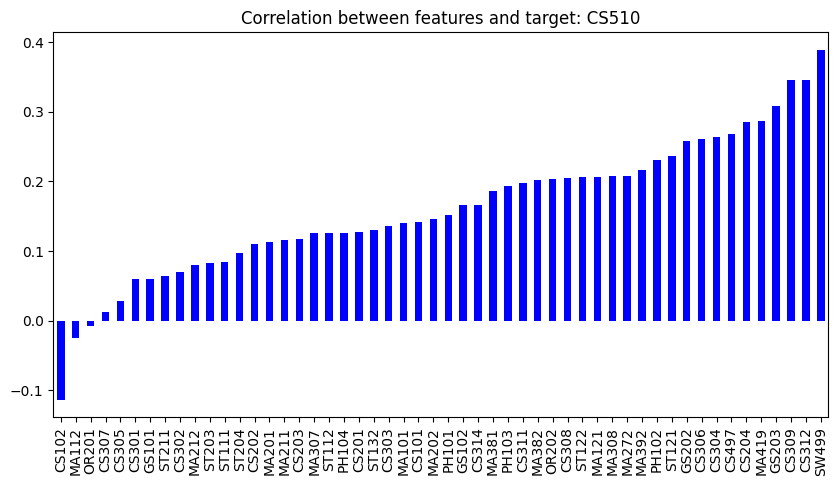

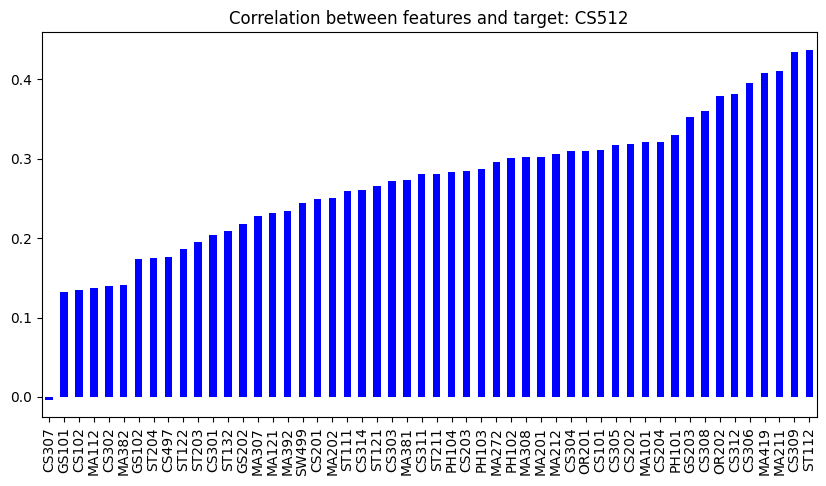

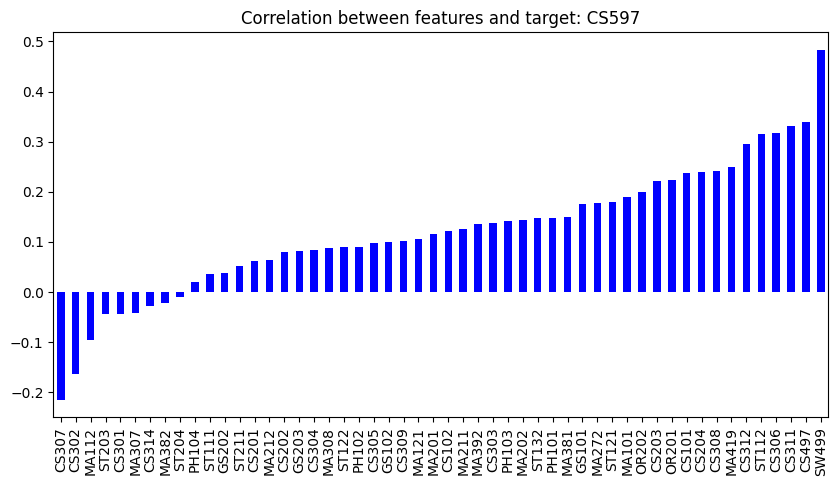

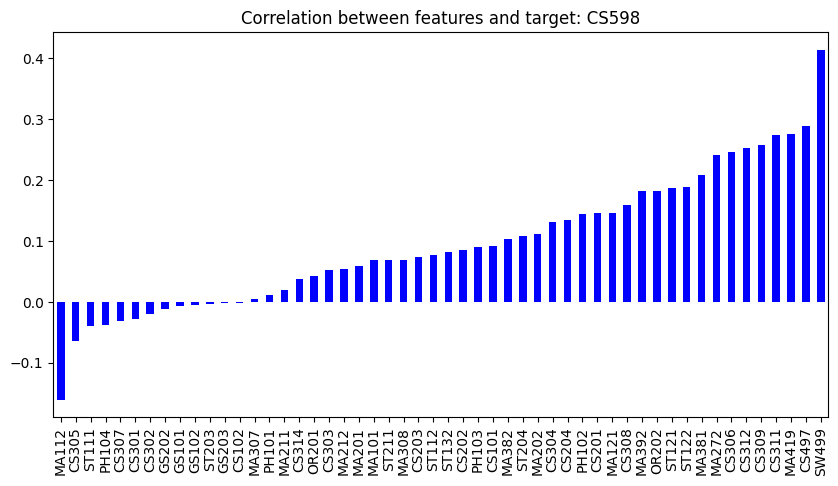

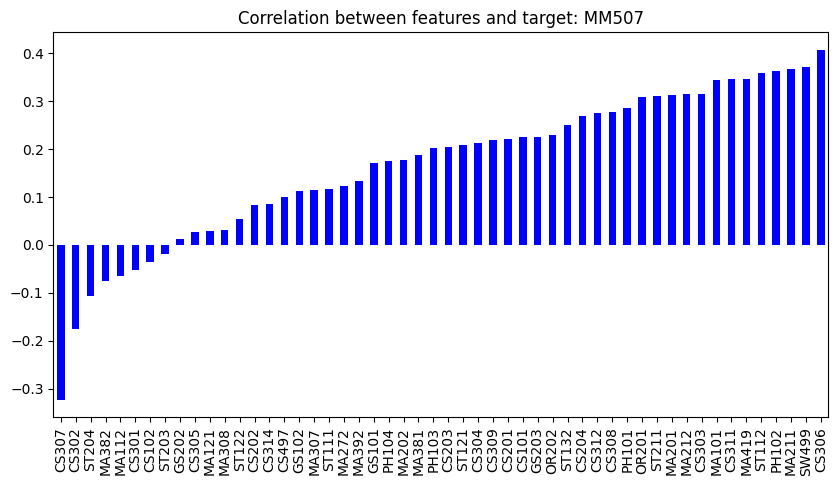

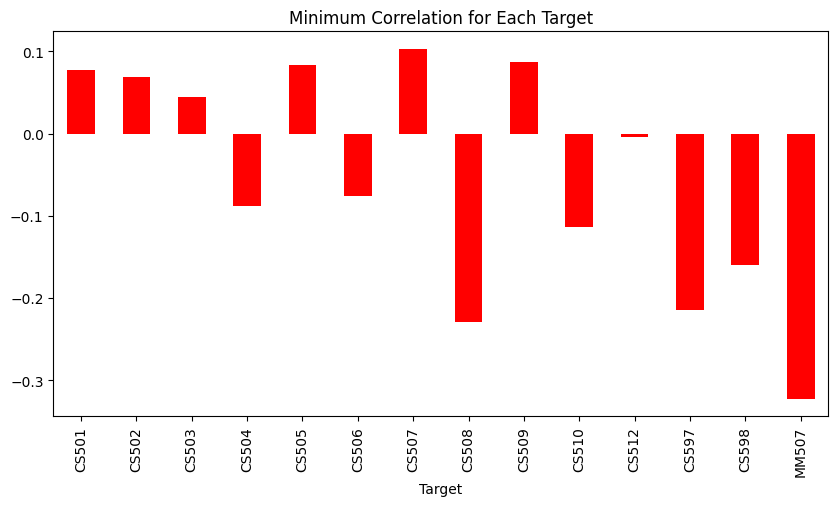

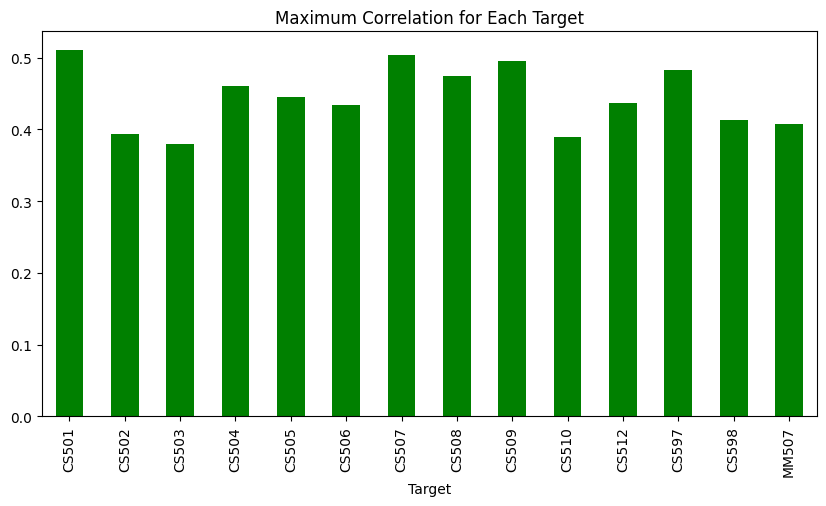

In [15]:
# List to store correlation data for each target
correlations = {}

# Iterate over each column in targets_encoded
for column in targets_encoded.columns:
    correlation = features_encoded.corrwith(targets_encoded[column])
    correlation.sort_values(inplace=True)
    correlations[column] = correlation

    # Plot the correlation between features and the current target
    plt.figure(figsize=(10, 5))
    correlation.plot(kind='bar', color='blue')
    plt.title(f'Correlation between features and target: {column}')
    plt.show()

# Plot min and max correlations for each target
min_correlations = {target: corr.min() for target, corr in correlations.items()}
max_correlations = {target: corr.max() for target, corr in correlations.items()}

# Convert to DataFrame for plotting
min_corr_df = pd.DataFrame(list(min_correlations.items()), columns=['Target', 'Min Correlation'])
max_corr_df = pd.DataFrame(list(max_correlations.items()), columns=['Target', 'Max Correlation'])

# Plot min correlations
plt.figure(figsize=(10, 5))
min_corr_df.set_index('Target')['Min Correlation'].plot(kind='bar', color='red')
plt.title('Minimum Correlation for Each Target')
plt.show()

# Plot max correlations
plt.figure(figsize=(10, 5))
max_corr_df.set_index('Target')['Max Correlation'].plot(kind='bar', color='green')
plt.title('Maximum Correlation for Each Target')
plt.show()

#### feature(encoded) distribution

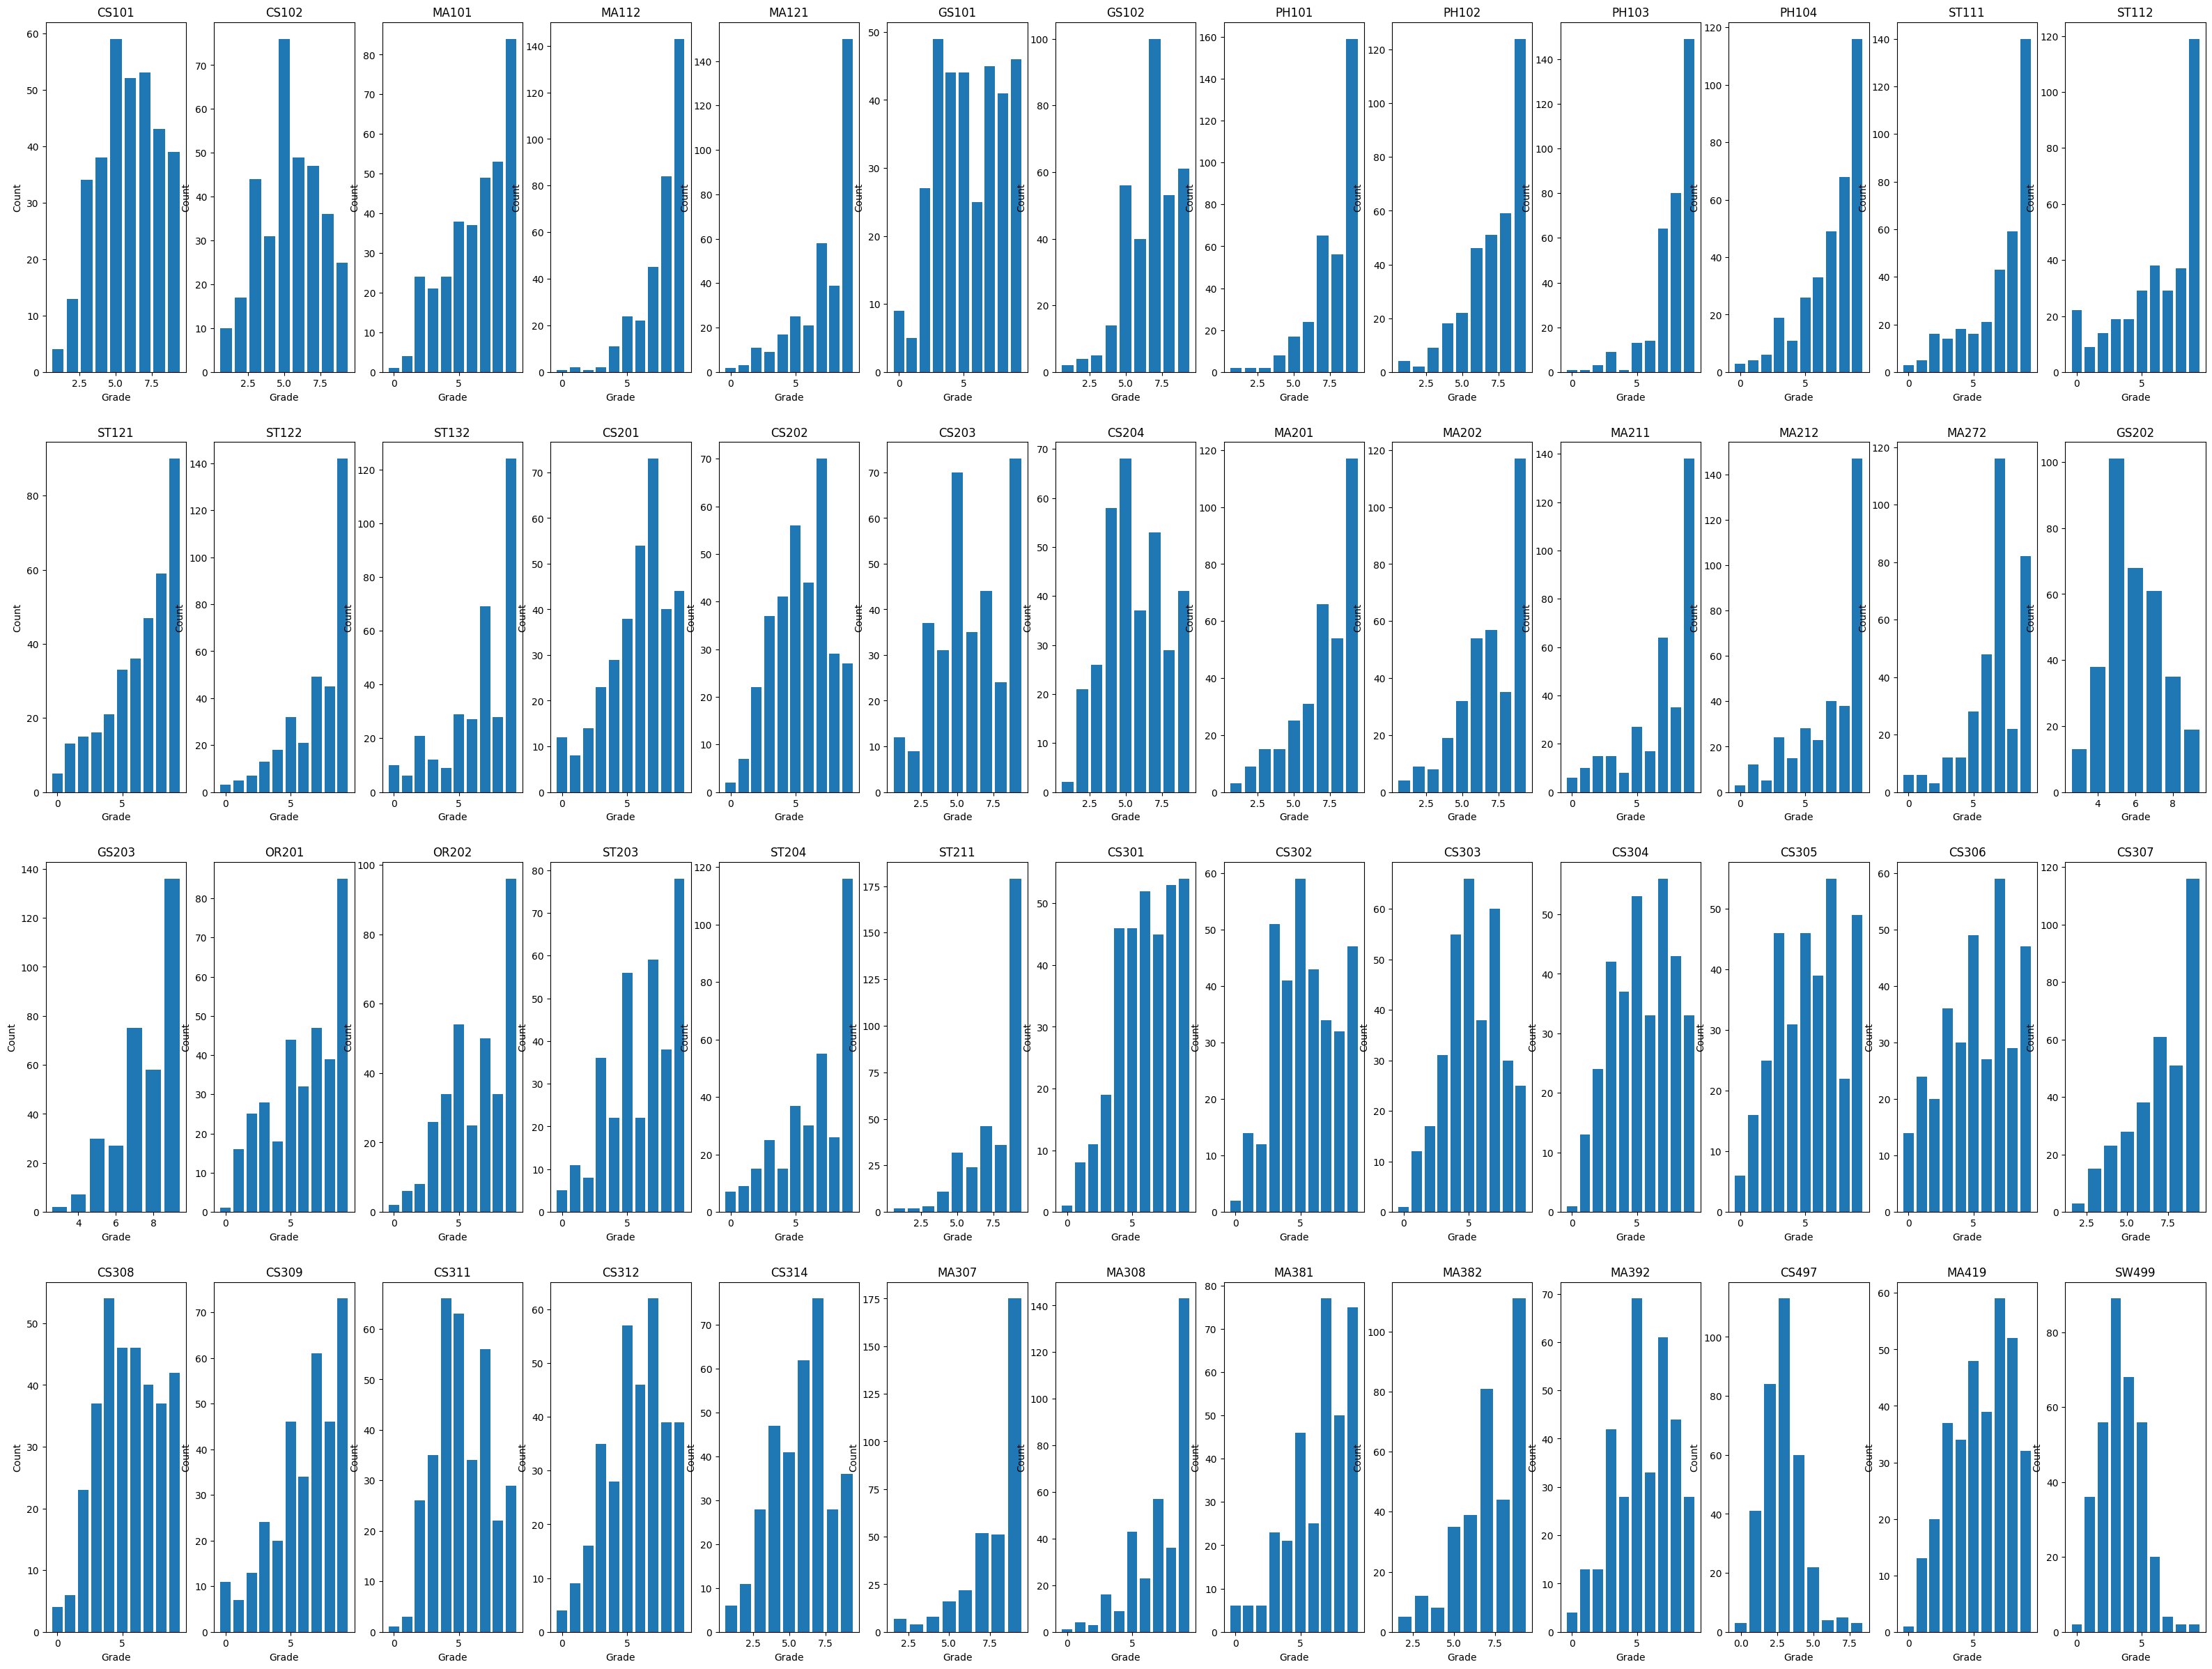

In [16]:
# plot subplot bar charts for each feature
plt.figure(figsize=(40, 30))
for i, col in enumerate(features.columns):
    plt.subplot(4, 13, i + 1)
    plt.bar(features_encoded[col].value_counts().index, features_encoded[col].value_counts().values)
    plt.title(col)
    plt.xlabel('Grade')
    plt.ylabel('Count')


#### balancing data set

##### vis

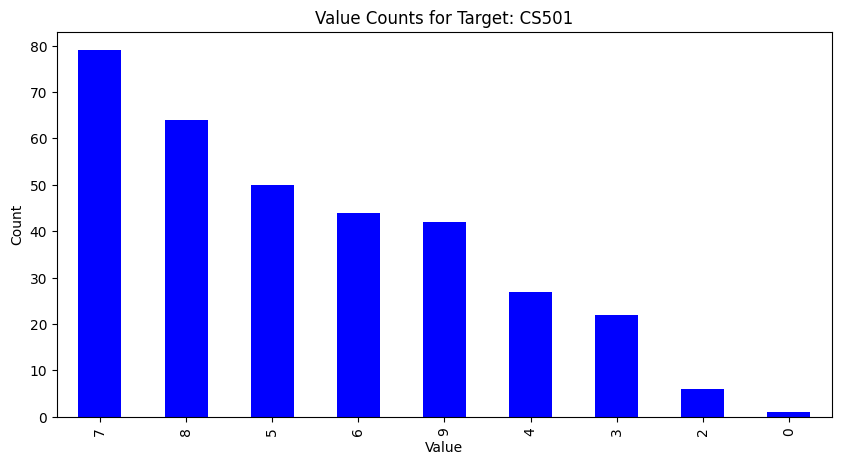

Value Counts for Target: CS501
CS501
7    79
8    64
5    50
6    44
9    42
4    27
3    22
2     6
0     1
Name: count, dtype: int64




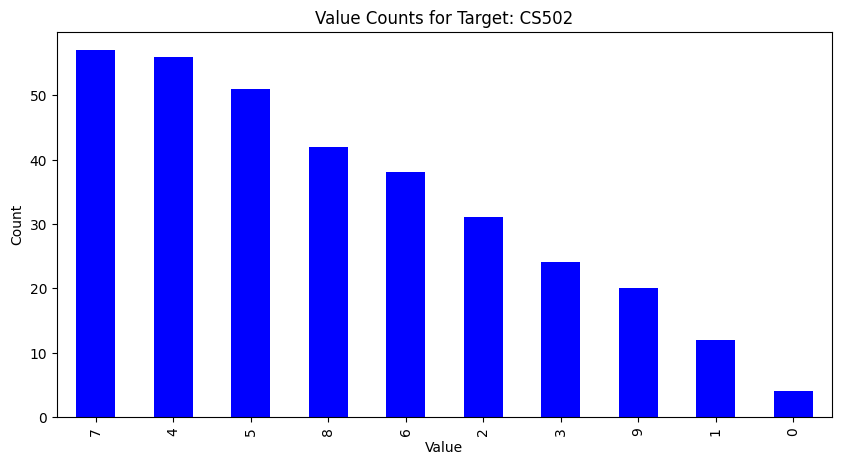

Value Counts for Target: CS502
CS502
7    57
4    56
5    51
8    42
6    38
2    31
3    24
9    20
1    12
0     4
Name: count, dtype: int64




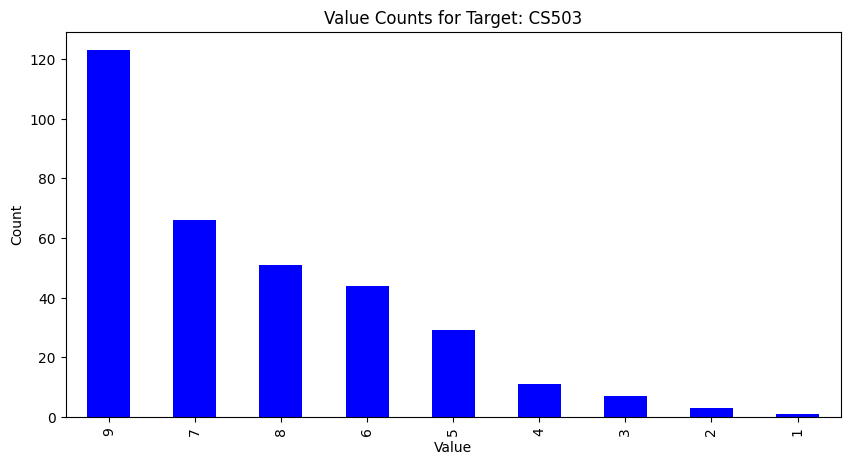

Value Counts for Target: CS503
CS503
9    123
7     66
8     51
6     44
5     29
4     11
3      7
2      3
1      1
Name: count, dtype: int64




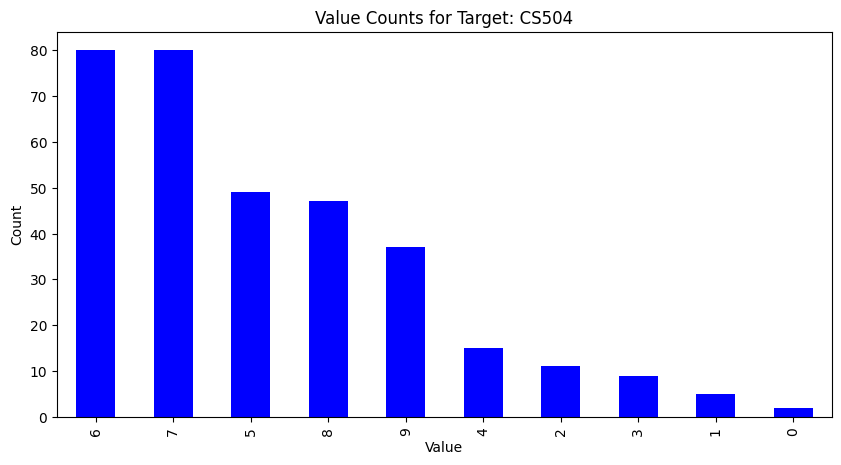

Value Counts for Target: CS504
CS504
6    80
7    80
5    49
8    47
9    37
4    15
2    11
3     9
1     5
0     2
Name: count, dtype: int64




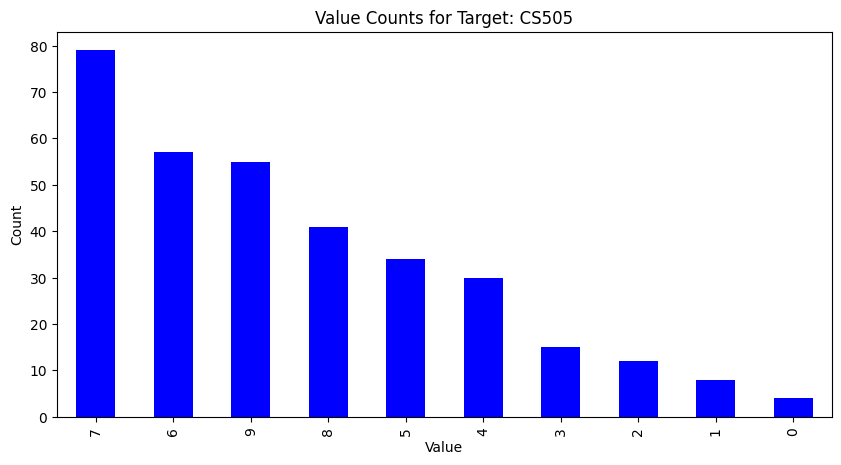

Value Counts for Target: CS505
CS505
7    79
6    57
9    55
8    41
5    34
4    30
3    15
2    12
1     8
0     4
Name: count, dtype: int64




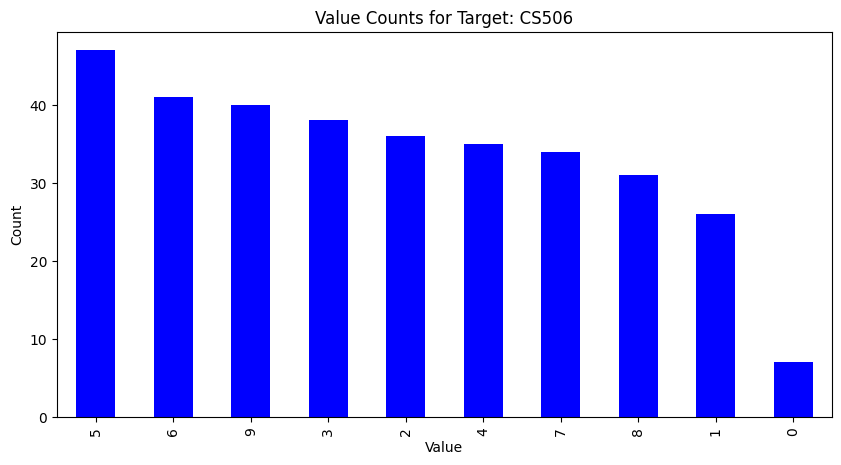

Value Counts for Target: CS506
CS506
5    47
6    41
9    40
3    38
2    36
4    35
7    34
8    31
1    26
0     7
Name: count, dtype: int64




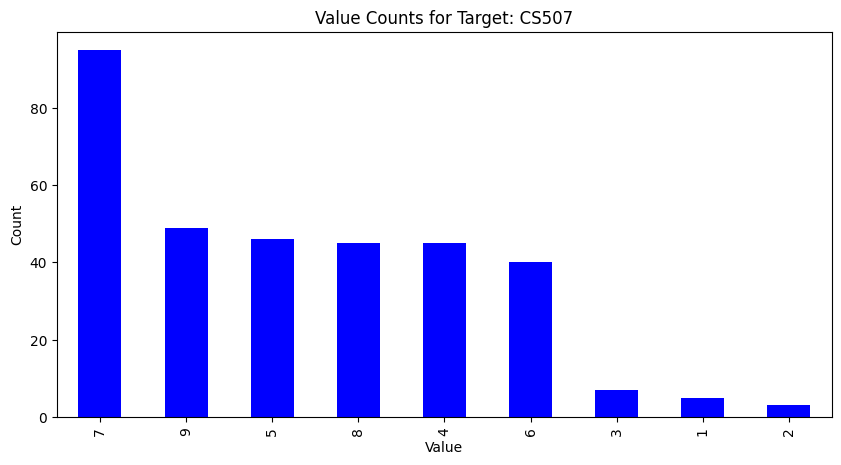

Value Counts for Target: CS507
CS507
7    95
9    49
5    46
8    45
4    45
6    40
3     7
1     5
2     3
Name: count, dtype: int64




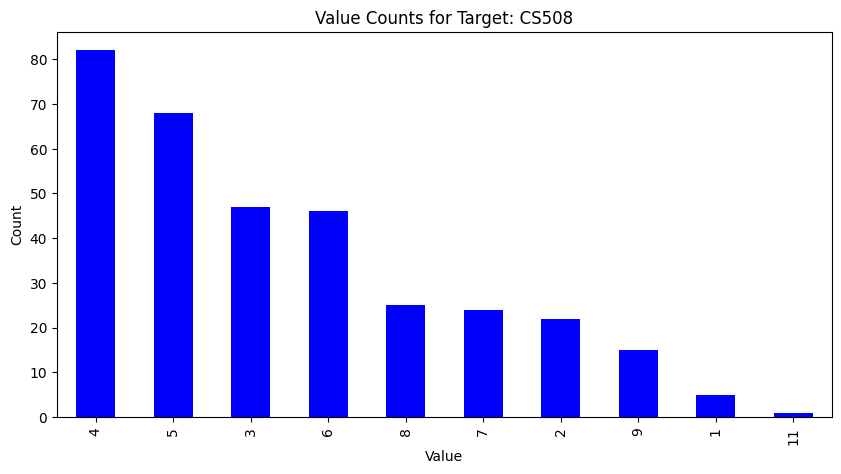

Value Counts for Target: CS508
CS508
4     82
5     68
3     47
6     46
8     25
7     24
2     22
9     15
1      5
11     1
Name: count, dtype: int64




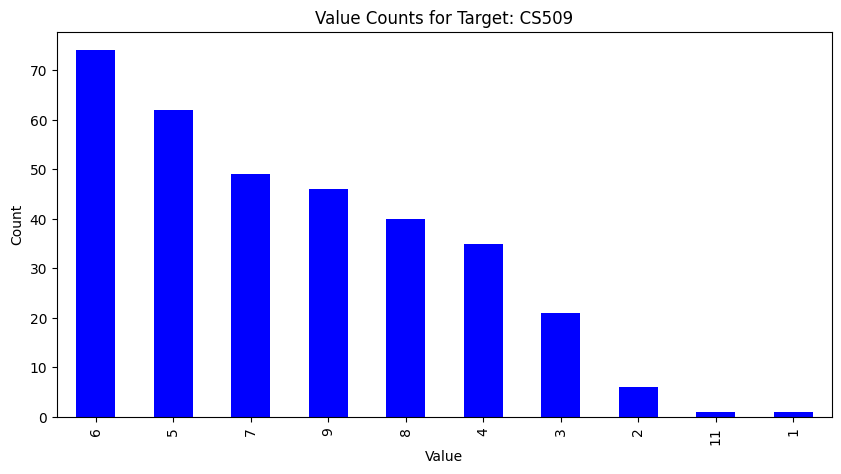

Value Counts for Target: CS509
CS509
6     74
5     62
7     49
9     46
8     40
4     35
3     21
2      6
11     1
1      1
Name: count, dtype: int64




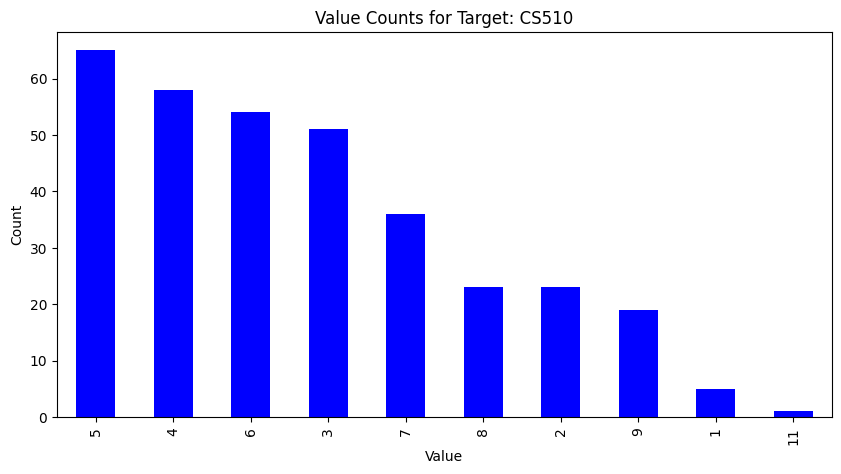

Value Counts for Target: CS510
CS510
5     65
4     58
6     54
3     51
7     36
8     23
2     23
9     19
1      5
11     1
Name: count, dtype: int64




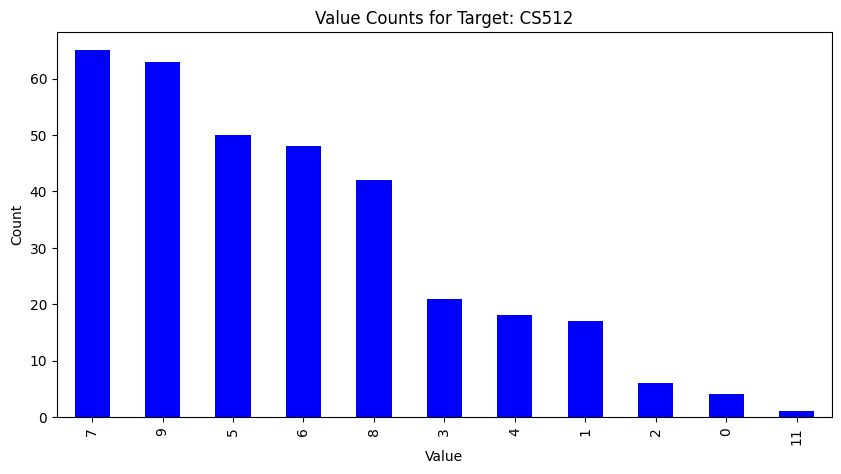

Value Counts for Target: CS512
CS512
7     65
9     63
5     50
6     48
8     42
3     21
4     18
1     17
2      6
0      4
11     1
Name: count, dtype: int64




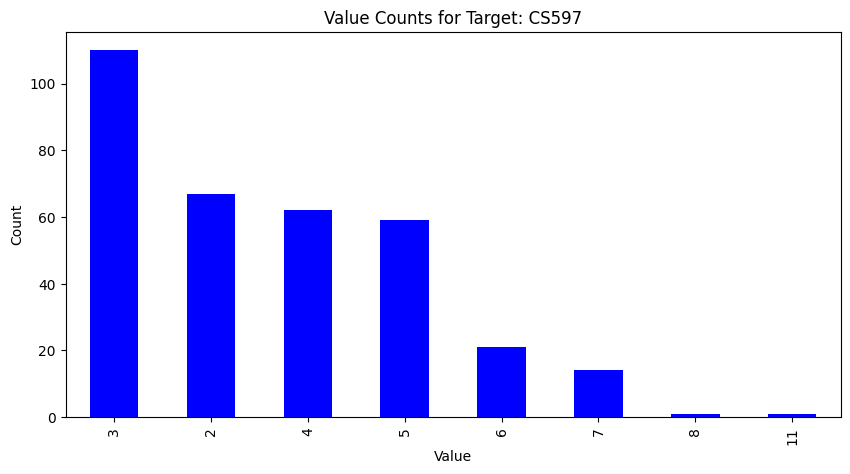

Value Counts for Target: CS597
CS597
3     110
2      67
4      62
5      59
6      21
7      14
8       1
11      1
Name: count, dtype: int64




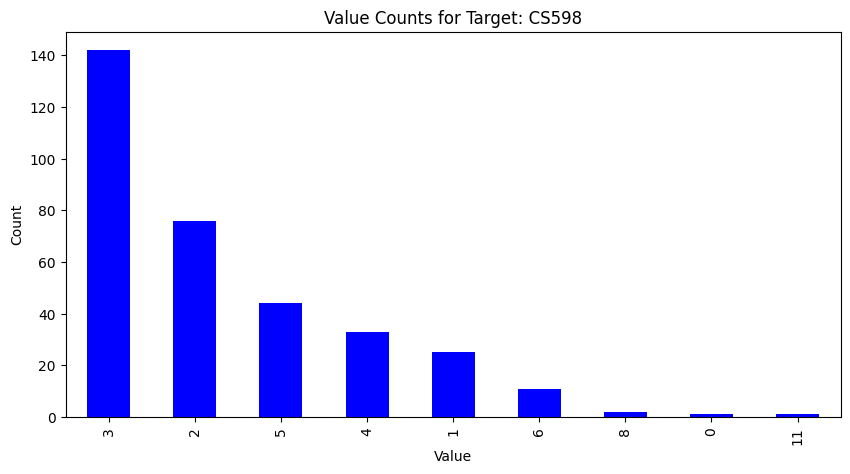

Value Counts for Target: CS598
CS598
3     142
2      76
5      44
4      33
1      25
6      11
8       2
0       1
11      1
Name: count, dtype: int64




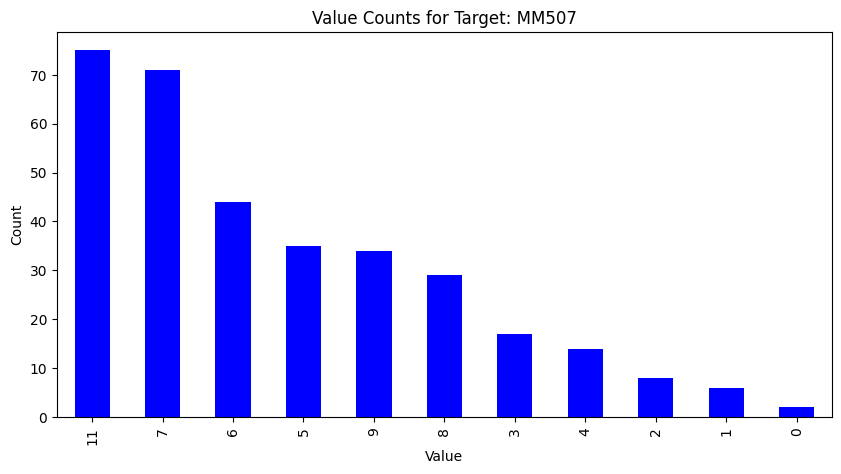

Value Counts for Target: MM507
MM507
11    75
7     71
6     44
5     35
9     34
8     29
3     17
4     14
2      8
1      6
0      2
Name: count, dtype: int64




In [17]:
# Iterate over each column in targets_encoded
for column in targets_encoded.columns:
    value_counts = targets_encoded[column].value_counts()
    
    # Plot the value counts as a bar chart
    plt.figure(figsize=(10, 5))
    value_counts.plot(kind='bar', color='blue')
    plt.title(f'Value Counts for Target: {column}')
    plt.xlabel('Value')
    plt.ylabel('Count')
    plt.show()
    
    # Print the value counts
    print(f'Value Counts for Target: {column}')
    print(value_counts)
    print('\n')

#### combine smaller classes to form classes with more than 4 samples 

In [18]:
# Function to merge small classes into the next larger class
def merge_small_classes(target_column, threshold=4):
    value_counts = target_column.value_counts()
    small_classes = value_counts[value_counts < threshold].index
    for small_class in small_classes:
        # Find the next larger class
        larger_classes = value_counts[value_counts >= threshold].index
        if len(larger_classes) > 0:
            next_larger_class = larger_classes[0]
            target_column[target_column == small_class] = next_larger_class
        else:
            # If no larger class exists, keep the class as is
            continue
    return target_column

# Iterate over each column in targets_encoded
for column in targets_encoded.columns:
    # Merge small classes in the target column
    targets_encoded[column] = merge_small_classes(targets_encoded[column])
    
    # Print the value counts after merging small classes
    value_counts = targets_encoded[column].value_counts()
    print(f'Value Counts for Target (after merging small classes): {column}')
    print(value_counts)
    print('\n')


Value Counts for Target (after merging small classes): CS501
CS501
7    80
8    64
5    50
6    44
9    42
4    27
3    22
2     6
Name: count, dtype: int64


Value Counts for Target (after merging small classes): CS502
CS502
7    57
4    56
5    51
8    42
6    38
2    31
3    24
9    20
1    12
0     4
Name: count, dtype: int64


Value Counts for Target (after merging small classes): CS503
CS503
9    127
7     66
8     51
6     44
5     29
4     11
3      7
Name: count, dtype: int64


Value Counts for Target (after merging small classes): CS504
CS504
6    82
7    80
5    49
8    47
9    37
4    15
2    11
3     9
1     5
Name: count, dtype: int64


Value Counts for Target (after merging small classes): CS505
CS505
7    79
6    57
9    55
8    41
5    34
4    30
3    15
2    12
1     8
0     4
Name: count, dtype: int64


Value Counts for Target (after merging small classes): CS506
CS506
5    47
6    41
9    40
3    38
2    36
4    35
7    34
8    31
1    26
0     7
Name: count, dtype:

In [43]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

from xgboost import XGBClassifier

##### Apply SMOTE technique to oversample

Resampled target value counts for MM507:
CS501
9    80
7    80
6    80
3    80
4    80
8    80
5    80
2    80
Name: count, dtype: int64


In [46]:
def train_xgboost_for_each_target(features_encoded, targets_encoded):
    results = {}

    # Iterate over each target column
    for column in targets_encoded.columns:
        print(f"Training XGBoost for target: {column}")

        # Apply SMOTE to the resampled dataset
        smote = SMOTE(k_neighbors=3)
        features_resampled, target_resampled = smote.fit_resample(features_encoded, targets_encoded[column])

        # Display the resampled target value counts
        print(f'Resampled target value counts for {column}:')
        print(pd.Series(target_resampled).value_counts())

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(features_resampled, target_resampled, test_size=0.2, random_state=42)

        # Encode target labels if they are not numeric
        le = LabelEncoder()
        y_train = le.fit_transform(y_train)
        y_test = le.transform(y_test)  # Use transform for consistency

        # Create an XGBoost classifier
        xgb = XGBClassifier()

        # Train the classifier
        xgb.fit(X_train, y_train)

        # Predict the target values
        y_pred = xgb.predict(X_test)

        # Calculate the accuracy of the classifier
        accuracy = accuracy_score(y_test, y_pred)
        results[f'{column}_accuracy'] = accuracy
        print(f'Accuracy: {accuracy}')

        # Calculate the precision, recall, and F1 score of the classifier
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        results[f'{column}_precision'] = precision
        results[f'{column}_recall'] = recall
        results[f'{column}_f1'] = f1

        # Display the precision, recall, and F1 score
        print(f'Precision: {precision}')
        print(f'Recall: {recall}')
        print(f'F1 Score: {f1}')

        # Calculate the confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)

        # Display the confusion matrix
        print('Confusion Matrix:')
        print(conf_matrix)
        print()

    return results



In [47]:
# Usage example:
results = train_xgboost_for_each_target(features_encoded, targets_encoded)
print("Results:")
print(results)

Training XGBoost for target: CS501
Resampled target value counts for CS501:
CS501
9    80
7    80
6    80
3    80
4    80
8    80
5    80
2    80
Name: count, dtype: int64
Accuracy: 0.7734375
Precision: 0.8018739073426574
Recall: 0.7734375
F1 Score: 0.7704418751893177
Confusion Matrix:
[[12  0  0  0  0  0  0  0]
 [ 0 16  0  0  1  0  1  0]
 [ 0  0 10  0  0  0  0  0]
 [ 0  0  1 12  0  2  1  2]
 [ 0  0  0  0 13  1  2  0]
 [ 0  0  2  0  5  8  7  0]
 [ 0  0  0  0  1  2 10  0]
 [ 0  0  0  0  0  0  1 18]]

Training XGBoost for target: CS502
Resampled target value counts for CS502:
CS502
4    57
7    57
0    57
6    57
8    57
1    57
2    57
5    57
3    57
9    57
Name: count, dtype: int64
Accuracy: 0.7105263157894737
Precision: 0.7202841505473084
Recall: 0.7105263157894737
F1 Score: 0.7079382328966816
Confusion Matrix:
[[10  1  0  0  0  0  0  0  0  0]
 [ 0 12  0  0  0  0  0  0  0  0]
 [ 0  0  7  0  0  1  1  0  0  0]
 [ 0  0  0  7  0  0  1  0  1  1]
 [ 0  0  0  1  6  1  4  1  0  0]
 [ 0  0  

# IGNORE BELOW CODE

### <u>training</u>

#### <i><span style="color:red"> function</span></i> : split train & test set 

In [20]:
def split_and_standardize(features, target, test_size=0.2, random_state=42):

    print("Spplitting and Standardizing the data...")
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=test_size, random_state=random_state)

    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

#### <i><span style="color:red"> function</span></i> : define model and params

In [60]:
def define_model_and_parameters():

    print("Defining the model and parameters...")

    # Create a neural network classifier
    clf = MLPClassifier(random_state=42, max_iter=300)

    # Define the hyperparameters to tune
    # parameters = {
    #     'hidden_layer_sizes': [(100,), (50,), (25,), (10,)],
    #     'activation': ['tanh', 'relu'],
    #     'solver': ['adam', 'sgd'],
    #     'alpha': [0.0001, 0.00001],
    #     'learning_rate': ['constant', 'adaptive'],
    # }
    parameters = {
    'hidden_layer_sizes': [(100,), (50,), (25,), (10,), (100, 50), (50, 25), (100, 50, 25)],  # Added more layers
    'activation': ['tanh', 'relu', 'logistic'],  # Added logistic activation
    'solver': ['adam', 'sgd', 'lbfgs'],  # Added lbfgs solver
    'alpha': [0.0001, 0.001, 0.01, 0.05],  # Added more alpha values
    'learning_rate': ['constant', 'adaptive', 'invscaling'],  # Added invscaling learning rate
    'batch_size': ['auto', 32, 64, 128],  # Added batch sizes
    'learning_rate_init': [0.001, 0.01, 0.1],  # Added initial learning rates
    'max_iter': [200, 300, 400]  # Added different maximum iteration values
    }


    return clf, parameters

#### <i><span style="color:red"> function</span></i> : find best params

In [37]:
def find_best_parameters(clf, parameters, X_train_scaled, y_train):

    print("Finding the best hyperparameters...")
    
    # Perform a grid search to find the best hyperparameters
    grid_search = GridSearchCV(clf, parameters, cv=5)
    grid_search.fit(X_train_scaled, y_train)

    # Get the best hyperparameters
    best_params = grid_search.best_params_
    print("Best hyperparameters:")
    print(best_params)
    
    return best_params

#### <i><span style="color:red"> function</span></i> : train using best params

In [38]:
def train_model_with_best_params(X_train_scaled, y_train, best_params):

    print("Training the model with the best hyperparameters...")
    
    # Create a neural network classifier with the best hyperparameters
    best_clf = MLPClassifier(random_state=1, max_iter=300, **best_params)

    # Train the classifier
    best_clf.fit(X_train_scaled, y_train)
    
    return best_clf

#### <i><span style="color:red"> function</span></i> : evaluate

In [39]:
def evaluate_model(best_clf, X_test_scaled, y_test):

    print("Evaluating the model...")
    
    # Predict the target values
    y_pred = best_clf.predict(X_test_scaled)

    # Calculate the evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    
    return accuracy, precision, recall, f1


#### <i><b><span style="color:green"> function</span></b></i> : Process a target

In [40]:
def process_target(features, target):

    print(f"Processing target : {target.name}")
    
    # Part 1: Split and standardize the data
    X_train_scaled, X_test_scaled, y_train, y_test = split_and_standardize(features, target)

    # Part 2: Define the model and parameters
    clf, parameters = define_model_and_parameters()

    # Part 3: Find the best parameters
    best_params = find_best_parameters(clf, parameters, X_train_scaled, y_train)

    # Part 4: Train the model with the best parameters
    best_clf = train_model_with_best_params(X_train_scaled, y_train, best_params)

    # Part 5: Evaluate the model
    accuracy, precision, recall, f1 = evaluate_model(best_clf, X_test_scaled, y_test)

    # Store the results
    result = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

    print("\n")

    return result




#### <i><b><span style="color:orange"> Execute </span></b></i> : Process All

In [61]:
result = process_target(features_encoded, targets_encoded['CS501'])

print(result)

Processing target : CS501
Spplitting and Standardizing the data...
Defining the model and parameters...
Finding the best hyperparameters...


In [6]:
# process only 1st target

# results = process_all_targets(features_encoded, features_encoded['CS501'])

# # Optional: Plotting the results
# for column, metrics in results.items():
#     print(f"Results for {column}:")
#     for metric, value in metrics.items():
#         print(f"{metric}: {value}")
#     print("\n")

In [ ]:
# cm = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(10, 7))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()


In [ ]:

# Plot the learning curve

# train_sizes, train_scores, test_scores = learning_curve(best_clf, X_train_scaled, y_train, cv=5)

# train_scores_mean = np.mean(train_scores, axis=1)
# test_scores_mean = np.mean(test_scores, axis=1) 

# plt.figure(figsize=(10, 7))
# plt.plot(train_sizes, train_scores_mean, label='Training Score')
# plt.plot(train_sizes, test_scores_mean, label='Cross-Validation Score')
# plt.xlabel('Training Examples')
# plt.ylabel('Score')
# plt.title('Learning Curve')
# plt.legend()
# plt.show()